In [75]:
import xarray as xr
import numpy as np
import glob2 as glob
import functions
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib as mpl
import seaborn as sns
from scipy import stats
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.markers import MarkerStyle

In [12]:
rpath = '/nird/datapeak/NS9600K/astridbg/arctic-cld-feedbacks/data/'

In [3]:
filepath = '/nird/datapeak/NS9600K/astridbg/arctic-cld-feedbacks/data/soil_moisture_ERA5/data_stream-moda.nc'
SM_ERA5 = xr.open_dataset(filepath)
SM_ERA5 = SM_ERA5.rename({'latitude':'lat', 'longitude':'lon', 'valid_time':'time'})
SM_ERA5_1994_2025 = SM_ERA5.sel(time=slice('1994-01-01','2025-09-01'))
SM_ERA5_1994_2025 = SM_ERA5_1994_2025.reindex(lat=list(reversed(SM_ERA5_1994_2025.lat)))
SM_ERA5_1994_2025.to_netcdf(rpath+'SM_ERA5_1994_2025.nc')

In [5]:
SM_ERA5_1994_2025 = xr.open_dataset(rpath+'SM_ERA5_1994_2025.nc')
SM_ERA5_1994_2025

<xarray.Dataset> Size: 2GB
Dimensions:  (time: 381, lat: 301, lon: 3600)
Coordinates:
  * time     (time) datetime64[ns] 3kB 1994-01-01 1994-02-01 ... 2025-09-01
  * lat      (lat) float64 2kB 60.0 60.1 60.2 60.3 60.4 ... 89.7 89.8 89.9 90.0
  * lon      (lon) float64 29kB -180.0 -179.9 -179.8 ... 179.7 179.8 179.9
    number   int64 8B ...
    expver   (time) <U4 6kB ...
Data variables:
    swvl1    (time, lat, lon) float32 2GB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-10-30T14:21 GRIB to CDM+CF via cfgrib-0.9.1...

In [20]:
filepath='/nird/datalake/NS9560K/diagnostics/ILAMB-Data/DATA/mrsos/WangMao/mrsos_olc.nc'

SM_WM = xr.open_dataset(filepath)
SM_WM_1994_2016 = SM_WM.sel(time=slice('1994-01-01','2016-12-31'),lat=slice(59,90))
SM_WM_1994_2016_masked = SM_WM_1994_2016.where(SM_WM_1994_2016['mrsos'] < 1000)
SM_WM_1994_2016_masked = SM_WM_1994_2016_masked.drop_vars('time_bounds')
SM_WM_1994_2016_masked.to_netcdf(rpath+'SM_WangMao_1994_2016_masked.nc')

In [6]:
SM_WM = xr.open_dataset(rpath+'SM_WangMao_1994_2016_masked.nc')
SM_WM

<xarray.Dataset> Size: 99MB
Dimensions:  (time: 276, lat: 62, lon: 720)
Coordinates:
  * time     (time) object 2kB 1994-01-16 12:00:00 ... 2016-12-16 12:00:00
  * lat      (lat) float64 496B 59.25 59.75 60.25 60.75 ... 88.75 89.25 89.75
  * lon      (lon) float64 6kB -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
Data variables:
    mrsos    (time, lat, lon) float64 99MB ...
Attributes:
    title:         Observation-based global multilayer soil moisture products...
    version:       1
    institutions:  Oak Ridge National Laboratory
    source:        Offline land surface models, reanalysis, and satellite soi...
    history:       \n2021-09-14: downloaded https://drive.google.com/file/d/1...
    references:    \n@ARTICLE{Wang2021,\n  author = {Wang, Y. and Mao, J. and...
    comments:      \ntime_period: 1970-01 through 2016-12; temporal_resolutio...
    convention:    CF-1.8

In [7]:
filepath = '/nird/datapeak/NS9600K/astridbg/arctic-cld-feedbacks/data/CERES_EBAF-TOA_Ed4.2_Subset_200207-202407.nc'
CERES = xr.open_dataset(filepath)

In [8]:
# Get land mask for CERES data

# Get land mask for NorESM2
filepath = '/nird/datapeak/NS9600K/astridbg/arctic-cld-feedbacks/data/other_cloud_vars/LANDFRAC_piClim.nc'
landfrac = xr.open_dataarray(filepath)
landmask = landfrac.isel(time=0)

# Interpolate to CERES data
landmask_CERES = landmask.interp_like(CERES.isel(time=0))
landmask_CERES = landmask_CERES.where(landmask_CERES>=0)
landmask_CERES = landmask_CERES.fillna(0)

In [15]:
SM_ERA5_trends_2002_2024 = xr.open_dataset(rpath+'soil_moisture_ERA5/SM_ERA5_trends_JJA_2002_2024.nc')
SM_ERA5_trends_2002_2024 = SM_ERA5_trends_2002_2024.rename({'latitude':'lat', 'longitude':'lon'})
SM_ERA5_trends_2002_2024 = SM_ERA5_trends_2002_2024.reindex(lat=list(reversed(SM_ERA5_trends_2002_2024.lat)))
SM_ERA5_trends_2002_2024.to_netcdf(rpath+'soil_moisture_ERA5/SM_ERA5_trends_JJA_2002_2024_correct.nc')

In [127]:
Arctic_limit=60
season='JJA'

# Compute JJA trend over land for CERES
# Regional average, Arctic land excluding Greenland (lons > 300)
CERES_Arctic = functions.computeWeightedMeanMasked(CERES['cldarea_total_daynight_mon'].sel(lat=slice(Arctic_limit, 90),lon=slice(0,300)), landmask_CERES.sel(lat=slice(Arctic_limit, 90),lon=slice(0,300)))
# Select season
CERES_season = CERES_Arctic.sel(time=CERES_Arctic.time.dt.season==season)
# Annual season mean
CERES_season_annual = CERES_season.groupby(CERES_season.time.dt.year).mean('time')
# Create linear regression
CERES_slope, CERES_intercept, CERES_r_value, CERES_p_value, CERES_std_err = stats.linregress(CERES_season_annual.year, CERES_season_annual.values)

# Compute JJA trend over land for ERA5-Land
timeslice=slice('1996-01-01','2024-12-13')
# Convert from m3/m3 to kg/m2 (*1000 kg/m3 *0.07 m = 70 kg/m2)
SM_ERA5_1994_2025_converted = SM_ERA5_1994_2025['swvl1']*70
# Regional average, Arctic excluding Greenland (lons > 300)
SM_ERA5_Arctic = functions.computeWeightedMean(SM_ERA5_1994_2025_converted.sel(time=timeslice,lon=slice(0,300)))
# Select season
SM_ERA5_season = SM_ERA5_Arctic.sel(time=SM_ERA5_Arctic.time.dt.season==season)
# Annual season mean
SM_ERA5_season_annual = SM_ERA5_season.groupby(SM_ERA5_season.time.dt.year).mean('time')
# Create linear regression
SM_ERA5_slope, SM_ERA5_intercept, SM_ERA5_r_value, SM_ERA5_p_value, SM_ERA5_std_err = stats.linregress(SM_ERA5_season_annual.year, SM_ERA5_season_annual.values)

# Compute JJA trend over land for Wang & Mao dataset
# Regional average, Arctic excluding Greenland (lons > 300)
timeslice=slice('1996-01-01','2016-12-13')
SM_WM_Arctic = functions.computeWeightedMean(SM_WM['mrsos'].sel(time=timeslice,lon=slice(0,300)))
# Select season
SM_WM_season = SM_WM_Arctic.sel(time=SM_WM_Arctic.time.dt.season==season)
# Annual season mean
SM_WM_season_annual = SM_WM_season.groupby(SM_WM_season.time.dt.year).mean('time')
# Create linear regression
SM_WM_slope, SM_WM_intercept, SM_WM_r_value, SM_WM_p_value, SM_WM_std_err = stats.linregress(SM_WM_season_annual.year, SM_WM_season_annual.values)


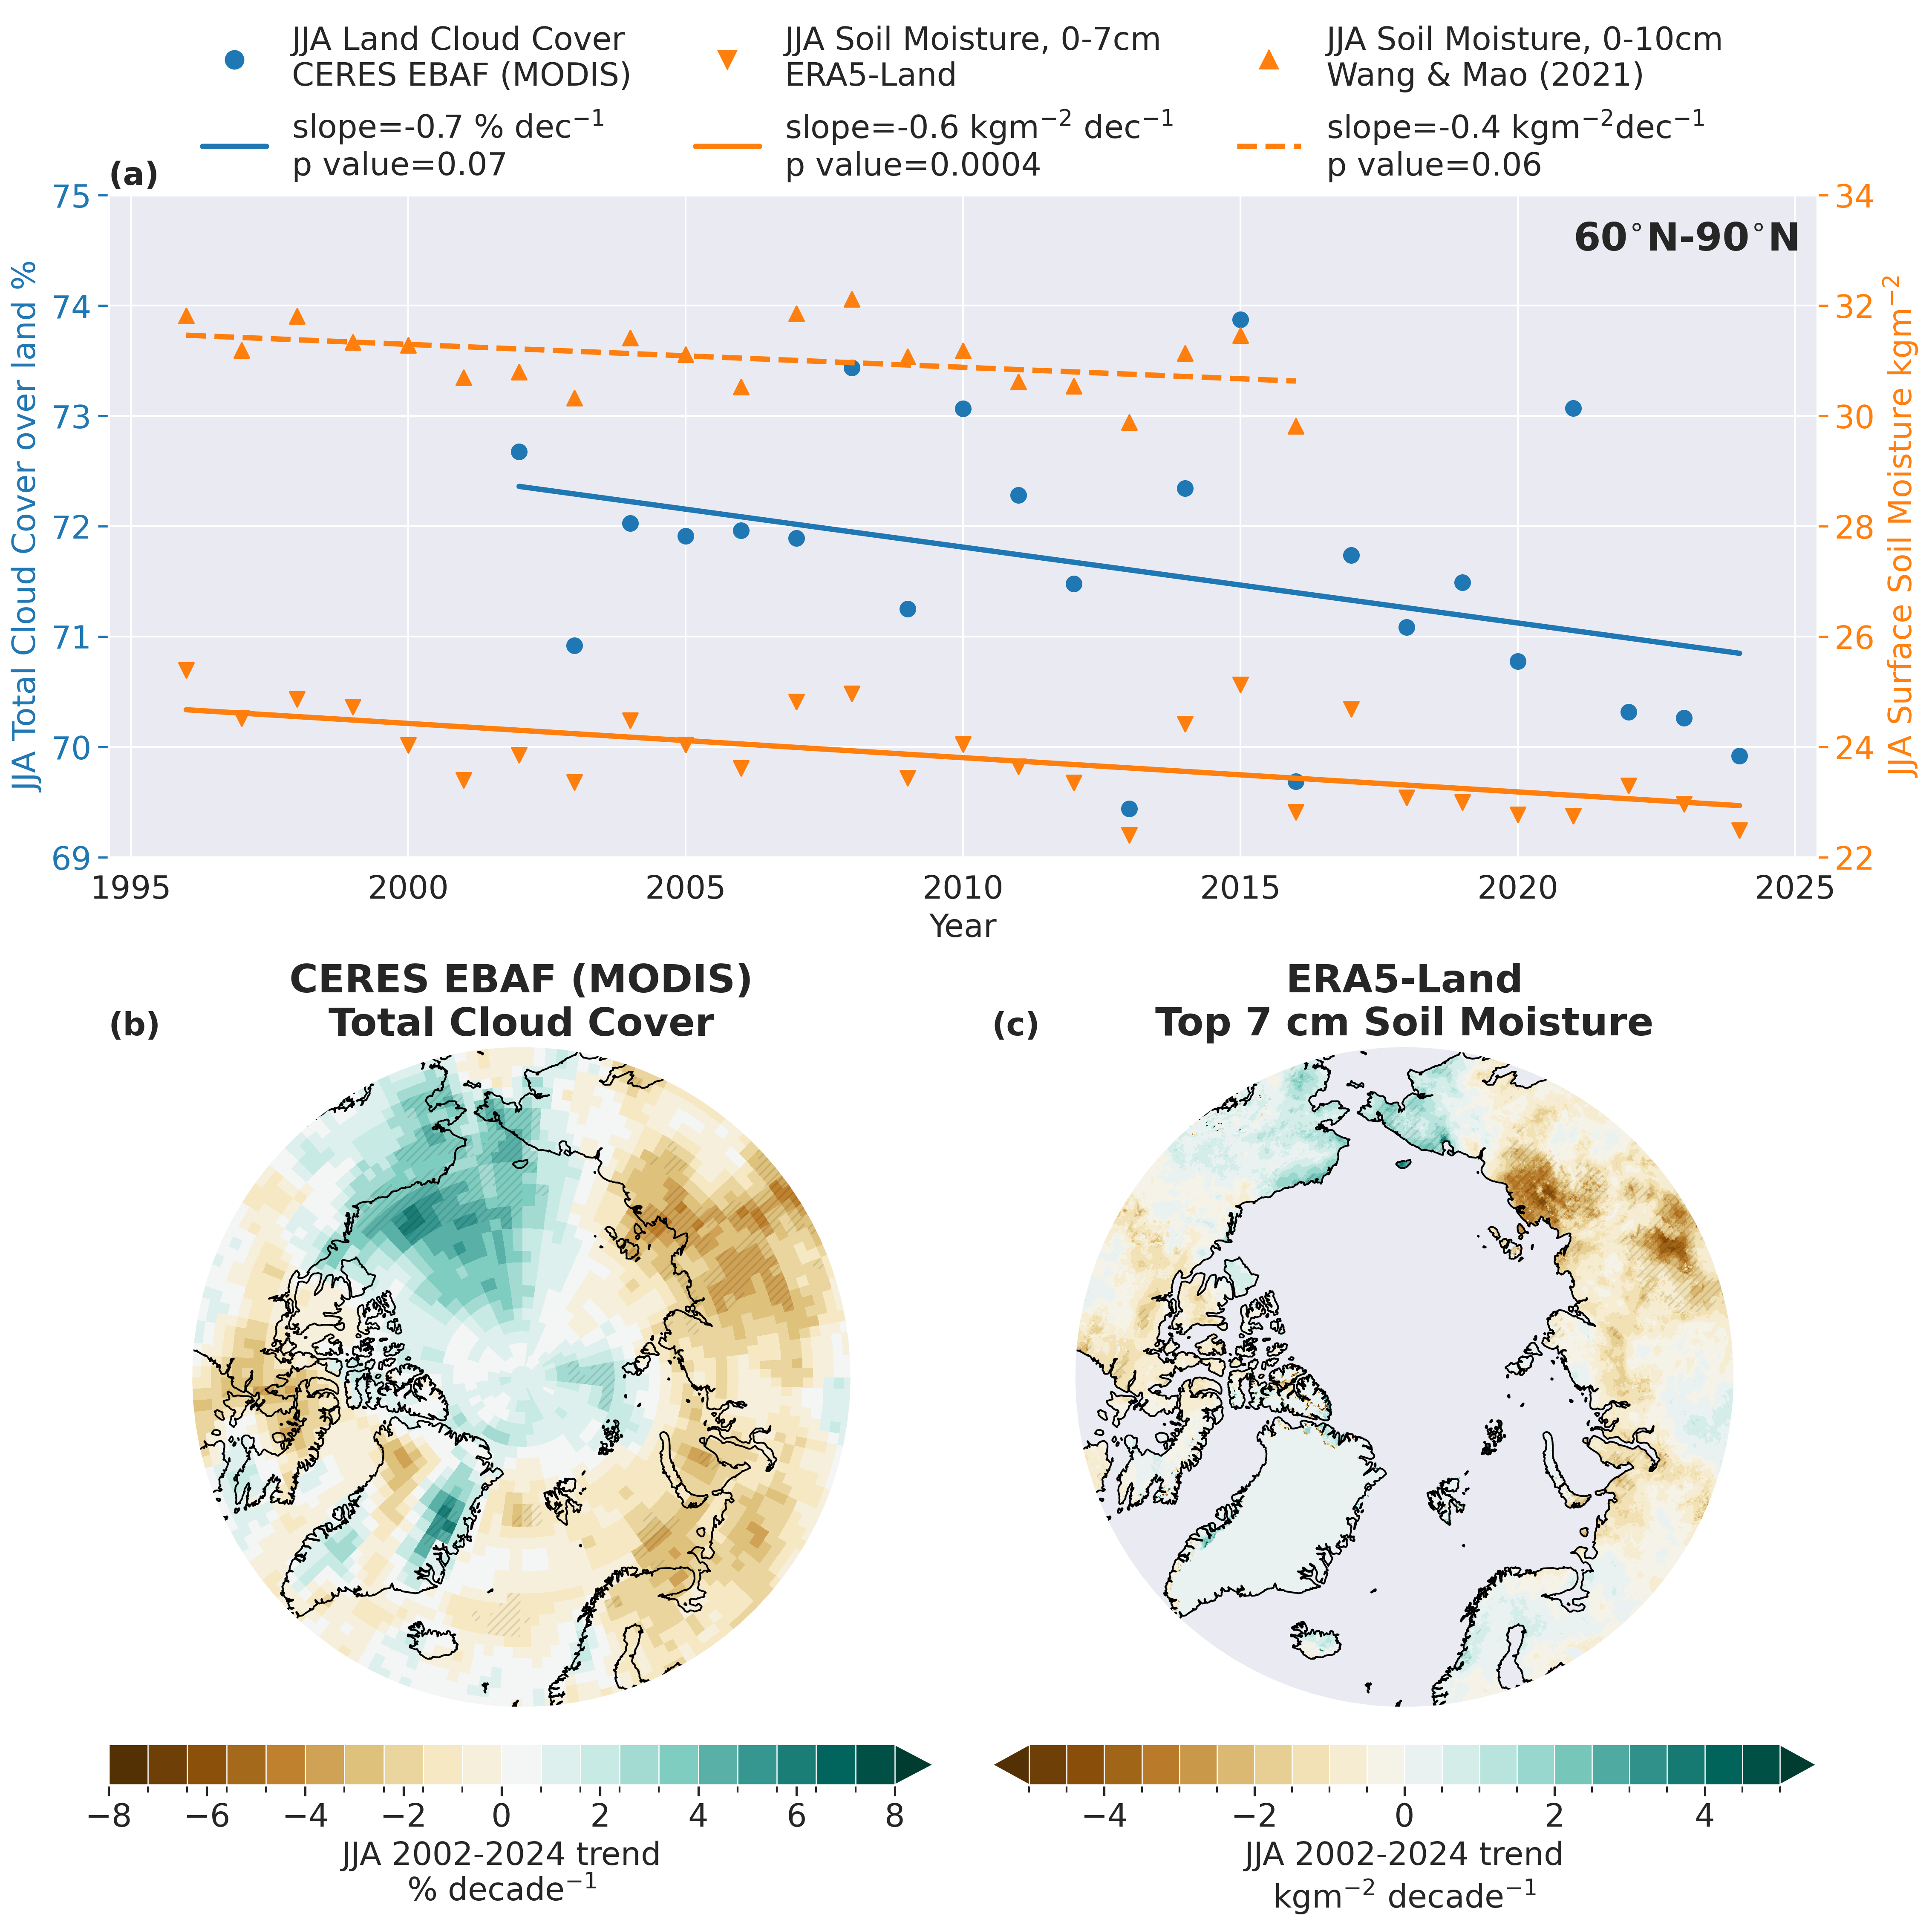

In [136]:
sns.set_theme()
labels = [['(a)','(a)'],['(b)','(c)']]

significance_level = 0.05
hatch_density = 5

# Create figure
fig, axs = plt.subplot_mosaic(mosaic=labels, figsize=(15, 15),dpi=300,constrained_layout=True)
# Remove axis from map plots
for label in labels[1]:
      ax = axs[label]
      ax.axis('off')
# Add new subplots with Arctic map projection
ax3 = fig.add_subplot(2, 2, 3, projection=ccrs.Orthographic(0, 90))
ax4 = fig.add_subplot(2, 2, 4, projection=ccrs.Orthographic(0, 90))


# Row 1: trends
ax = axs['(a)']
ax2 = ax.twinx()

CERES_color='tab:blue'
for i in range(0, len(CERES_season_annual.year)):
    ax.scatter(CERES_season_annual.year[i], CERES_season_annual.isel(year=i), color=CERES_color, s=70)
ax.plot(CERES_season_annual.year, CERES_intercept+CERES_slope*CERES_season_annual.year, color=CERES_color, lw=3)

SM_color = 'tab:orange'
for i in range(0, len(SM_ERA5_season_annual.year)):
    ax2.scatter(SM_ERA5_season_annual.year[i], SM_ERA5_season_annual.isel(year=i), color=SM_color, marker='v',s=70)
ax2.plot(SM_ERA5_season_annual.year, SM_ERA5_intercept+SM_ERA5_slope*SM_ERA5_season_annual.year, color=SM_color, lw=3)

for i in range(0, len(SM_WM_season_annual.year)):
    ax2.scatter(SM_WM_season_annual.year[i], SM_WM_season_annual.isel(year=i), color=SM_color, marker='^', s=70)
ax2.plot(SM_WM_season_annual.year, SM_WM_intercept+SM_WM_slope*SM_WM_season_annual.year, color=SM_color, ls='--',lw=3)

legend_elements = [Line2D([0], [0], marker='o',color='None',mec=CERES_color,mfc=CERES_color, markersize=10, label='JJA Land Cloud Cover\nCERES EBAF (MODIS)'),
                   Line2D([0], [0], color=CERES_color, lw=3, linestyle='-', label='slope='+str(np.round(CERES_slope*10,1))+' % dec$^{-1}$\np value='+str(np.round(CERES_p_value,2))),
                   Line2D([0], [0], marker='v',color='None',mec=SM_color,mfc=SM_color, markersize=10, label='JJA Soil Moisture, 0-7cm\nERA5-Land'),
                   Line2D([0], [0], color=SM_color, lw=3, linestyle='-', label='slope='+str(np.round(SM_ERA5_slope*10,1))+' kgm$^{-2}$ dec$^{-1}$\np value='+str(np.round(SM_ERA5_p_value,4))),
                   Line2D([0], [0], marker='^',color='None',mec=SM_color,mfc=SM_color, markersize=10, label='JJA Soil Moisture, 0-10cm\nWang & Mao (2021)'),
                   Line2D([0], [0], color=SM_color, lw=3, linestyle='--', label='slope='+str(np.round(SM_WM_slope*10,1))+' kgm$^{-2} $dec$^{-1}$\np value='+str(np.round(SM_WM_p_value,2))),]

#plt.grid()
#ax.set_title('Latitudes > 60$^{\circ}$N', fontsize=22, fontweight='bold')
years = [1995, 2000, 2005, 2010, 2015, 2020, 2025]
ax.set_xticks(years)
ax.set_xticklabels(years, fontsize=18)

ax.text(2021, 74.5, '60$^{\circ}$N-90$^{\circ}$N', fontsize=22, fontweight='bold')
ax.set_xlabel('Year', fontsize=18)
ax.set_ylabel('JJA Total Cloud Cover over land %', fontsize=18)
ax.yaxis.label.set_color(CERES_color)
ax.tick_params(axis='y', colors=CERES_color)
ax.set_ylim([69, 75])
ax.set_yticks([69, 70, 71, 72, 73, 74, 75])
ax.set_yticklabels([69, 70, 71, 72, 73, 74, 75], fontsize=18)

ax2.set_xlabel('Year')
ax2.set_ylabel('JJA Surface Soil Moisture kgm$^{-2}$', fontsize=18)
ax2.yaxis.label.set_color(SM_color)
ax2.tick_params(axis='y', colors=SM_color)
ax2.set_ylim([22, 34])
ax2.set_yticks([22, 24, 26, 28, 30, 32, 34])
ax2.set_yticklabels([22, 24, 26, 28, 30, 32, 34], fontsize=18)
ax2.grid()

ax.legend(handles=legend_elements, ncols=3, loc='upper center', 
    bbox_to_anchor=(0.5, 1.3),frameon=False, fontsize=18)


# Row 2: spatial trends
for ax, title, unit, file, limit in zip([ax3, ax4], 
                                  ['CERES EBAF (MODIS)\nTotal Cloud Cover', 'ERA5-Land\nTop 7 cm Soil Moisture'],
                                  ['% decade$^{-1}$', 'kgm$^{-2}$ decade$^{-1}$'],
                                  ['CERES_trends_JJA.nc', 'soil_moisture_ERA5/SM_ERA5_trends_JJA_2002_2024_correct.nc'], 
                                  [8, 5]):
    levels = np.linspace(-limit, limit, 21)
    functions.polarCentral_set_latlim([60,90], ax)
    ds = xr.open_dataset(rpath+file)
    data = ds['trend'].T*10 # multiply by 10 to get trend per decade
    map = data.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), 
                                        cmap='BrBG', levels=levels,
                                        add_colorbar=False)
    #hatch = ax.contourf(ds.lon, ds.lat, ds['p_value'].T < significance_level, transform=ccrs.PlateCarree(), colors='none', levels=[.5,1.5], hatches=[hatch_density*'.', hatch_density*'.'])
    hatch = ax.contourf(ds.lon, ds.lat, ds['p_value'].T < significance_level, transform=ccrs.PlateCarree(), colors='none', levels=[.5,1.5], hatches=[hatch_density*'/', hatch_density*'/'])    
    #hatch.set_edgecolor('black')
    #hatch._hatch_color = (1, 1, 1, 1.0)
    hatch._hatch_color = (0, 0, 0, 0.1)
    ax.set_title(title, fontsize=22, fontweight='bold')
    ax.coastlines()

    cb = plt.colorbar(map, ax=ax, ticks=[-10, -8,-6,-4,-2,0,2,4,6,8,10],drawedges=True,
                        location='bottom',orientation='horizontal')

    cb.set_label(label='JJA 2002-2024 trend\n'+unit,fontsize=18)
    cb.ax.tick_params(labelsize=18)

# Label subplots
for label, ax in axs.items():
    ax.set_title(label, loc='left', fontsize=18,fontweight='bold')

fig.savefig('/nird/datapeak/NS9600K/astridbg/arctic-cld-feedbacks/arctic-cloud-feedbacks/article_figs/Fig4.png')
fig.savefig('/nird/datapeak/NS9600K/astridbg/arctic-cld-feedbacks/arctic-cloud-feedbacks/article_figs/Fig4.pdf')

In [13]:
rpath = '/nird/datapeak/NS9600K/astridbg/arctic-cld-feedbacks/'
CERES = xr.open_dataset(rpath+'CERES_EBAF-TOA_Ed4.2_Subset_200207-202407.nc')

from scipy import stats
for season in ["JJA"]:
    ds_season = CERES['cldarea_total_daynight_mon'].sel(time=CERES.time.dt.season==season)
    ds_annual = ds_season.groupby(ds_season.time.dt.year).mean('time')

    trends = np.ones((len(CERES.lon),len(CERES.lat)))*np.nan
    p_values = np.ones((len(CERES.lon),len(CERES.lat)))*np.nan
    for ilon in range(len(CERES.lon)):
        for ilat in range(len(CERES.lat)):
            slope, intercept, r_value, p_value, std_err = stats.linregress(ds_annual.year, ds_annual.isel(lon=ilon, lat=ilat))
            trends[ilon, ilat] = slope
            p_values[ilon, ilat] = p_value
    
    ds_annual['trend'] = ({'lon':CERES.lon, 'lat':CERES.lat}, trends)
    ds_annual['p_value'] = ({'lon':CERES.lon, 'lat':CERES.lat}, p_values)

    ds_annual.to_netcdf(rpath+"CERES_trends_"+season+".nc")

In [6]:
rpath = '/nird/datapeak/NS9600K/astridbg/arctic-cld-feedbacks/data/'
CERES = xr.open_dataset(rpath+'CERES_EBAF-TOA_Ed4.2_Subset_200207-202407.nc')

datadir = '/nird/datapeak/NS9600K/astridbg/arctic-cld-feedbacks/data/other_cloud_vars/'
landfrac = xr.open_dataarray(datadir+'LANDFRAC_piClim.nc')
landmask = landfrac.isel(time=0)
oceanmask = 1-landmask

# Interpolate to 
landmask_CERES = landmask.interp_like(CERES.isel(time=0))
landmask_CERES = landmask_CERES.where(landmask_CERES>=0)
landmask_CERES = landmask_CERES.fillna(0)

oceanmask_CERES = 1-landmask_CERES

In [ ]:
from scipy import stats
savedir="/nird/datapeak/NS9600K/astridbg/arctic-cld-feedbacks/data/soil_moisture_ERA5/"

#for season in ["DJF", "MAM","JJA","SON"]:
for season in ["JJA"]:
    ds_season = SM_ERA5.sel(valid_time=SM_ERA5.valid_time.dt.season==season)
    ds_annual = ds_season.groupby(ds_season.valid_time.dt.year).mean('valid_time')
    converted_ds_annual = ds_annual[var]*70 # from m3/m3 to kg/m2

    trends = np.ones((len(SM_ERA5.longitude),len(SM_ERA5.latitude)))*np.nan
    p_values = np.ones((len(SM_ERA5.longitude),len(SM_ERA5.latitude)))*np.nan
    for ilon in range(len(SM_ERA5.longitude)):
        for ilat in range(len(SM_ERA5.latitude)):
            slope, intercept, r_value, p_value, std_err = stats.linregress(converted_ds_annual.year, converted_ds_annual.isel(longitude=ilon, latitude=ilat))
            trends[ilon, ilat] = slope
            p_values[ilon, ilat] = p_value
    
    ds_annual['trend'] = ({'longitude':SM_ERA5.longitude, 'latitude':SM_ERA5.latitude}, trends)
    ds_annual['p_value'] = ({'longitude':SM_ERA5.longitude, 'latitude':SM_ERA5.latitude}, p_values)

    ds_annual.to_netcdf(savedir+"SM_ERA5_trends_"+season+".nc")

In [70]:
var = 'swvl1'
ds_season = SM_ERA5.sel(valid_time=SM_ERA5.valid_time.dt.season==season)
ds_annual = ds_season.groupby(ds_season.valid_time.dt.year).mean('valid_time')
converted_ds_annual = ds_annual[var]*70 # from m3/m3 to kg/m2

In [ ]:
from scipy import stats
savedir="/nird/datapeak/NS9600K/astridbg/arctic-cld-feedbacks/data/soil_moisture_ERA5/"

#for season in ["DJF", "MAM","JJA","SON"]:
for season in ["JJA"]:
    ds_season = SM_ERA5.sel(valid_time=SM_ERA5.valid_time.dt.season==season)
    ds_annual = ds_season.groupby(ds_season.valid_time.dt.year).mean('valid_time')
    converted_ds_annual = ds_annual[var]*70 # from m3/m3 to kg/m2

    trends = np.ones((len(SM_ERA5.longitude),len(SM_ERA5.latitude)))*np.nan
    p_values = np.ones((len(SM_ERA5.longitude),len(SM_ERA5.latitude)))*np.nan
    for ilon in range(len(SM_ERA5.longitude)):
        for ilat in range(len(SM_ERA5.latitude)):
            slope, intercept, r_value, p_value, std_err = stats.linregress(converted_ds_annual.year, converted_ds_annual.isel(longitude=ilon, latitude=ilat))
            trends[ilon, ilat] = slope
            p_values[ilon, ilat] = p_value
    
    ds_annual['trend'] = ({'longitude':SM_ERA5.longitude, 'latitude':SM_ERA5.latitude}, trends)
    ds_annual['p_value'] = ({'longitude':SM_ERA5.longitude, 'latitude':SM_ERA5.latitude}, p_values)

    ds_annual.to_netcdf(savedir+"SM_ERA5_trends_"+season+".nc")


In [75]:
from scipy import stats
savedir="/nird/datapeak/NS9600K/astridbg/arctic-cld-feedbacks/data/soil_moisture_ERA5/"

#for season in ["DJF", "MAM","JJA","SON"]:
for season in ["JJA"]:
    ds_season = SM_ERA5.sel(valid_time=SM_ERA5.valid_time.dt.season==season)
    ds_annual = ds_season.groupby(ds_season.valid_time.dt.year).mean('valid_time')
    converted_ds_annual = ds_annual[var]*70 # from m3/m3 to kg/m2

    trends = np.ones((len(SM_ERA5.longitude),len(SM_ERA5.latitude)))*np.nan
    p_values = np.ones((len(SM_ERA5.longitude),len(SM_ERA5.latitude)))*np.nan
    for ilon in range(len(SM_ERA5.longitude)):
        for ilat in range(len(SM_ERA5.latitude)):
            slope, intercept, r_value, p_value, std_err = stats.linregress(converted_ds_annual.year.sel(year=slice(2002,2024)), converted_ds_annual.isel(longitude=ilon, latitude=ilat).sel(year=slice(2002,2024)))
            trends[ilon, ilat] = slope
            p_values[ilon, ilat] = p_value
    
    ds_annual['trend'] = ({'longitude':SM_ERA5.longitude, 'latitude':SM_ERA5.latitude}, trends)
    ds_annual['p_value'] = ({'longitude':SM_ERA5.longitude, 'latitude':SM_ERA5.latitude}, p_values)

    ds_annual.to_netcdf(savedir+"SM_ERA5_trends_"+season+"_2002_2024.nc")


In [25]:
from scipy import stats
savedir="/nird/datapeak/NS9600K/astridbg/arctic-cld-feedbacks/data/soil_moisture_ERA5/"
var='swvl1'

#for season in ["DJF", "MAM","JJA","SON"]:
for season in ["JJA"]:
    ds_season = SM_ERA5.sel(valid_time=SM_ERA5.valid_time.dt.season==season)
    ds_annual = ds_season.groupby(ds_season.valid_time.dt.year).mean('valid_time')
    converted_ds_annual = ds_annual[var]*70 # from m3/m3 to kg/m2

    trends = np.ones((len(SM_ERA5.longitude),len(SM_ERA5.latitude)))*np.nan
    p_values = np.ones((len(SM_ERA5.longitude),len(SM_ERA5.latitude)))*np.nan
    for ilon in range(len(SM_ERA5.longitude)):
        for ilat in range(len(SM_ERA5.latitude)):
            slope, intercept, r_value, p_value, std_err = stats.linregress(converted_ds_annual.year.sel(year=slice(1970,2016)), converted_ds_annual.isel(longitude=ilon, latitude=ilat).sel(year=slice(1970,2016)))
            trends[ilon, ilat] = slope
            p_values[ilon, ilat] = p_value
    
    ds_annual['trend'] = ({'longitude':SM_ERA5.longitude, 'latitude':SM_ERA5.latitude}, trends)
    ds_annual['p_value'] = ({'longitude':SM_ERA5.longitude, 'latitude':SM_ERA5.latitude}, p_values)

    ds_annual.to_netcdf(savedir+"SM_ERA5_trends_"+season+"_1970_2016.nc")


In [4]:
season="JJA"
rpath = "/nird/datapeak/NS9600K/astridbg/arctic-cld-feedbacks/data/soil_moisture_ERA5/"
ds_annual = xr.open_dataset(rpath+"SM_ERA5_trends_"+season+".nc")
ds_annual = ds_annual.reindex(latitude=list(reversed(ds_annual.latitude)))

In [4]:
filepath='/nird/datalake/NS9560K/diagnostics/ILAMB-Data/DATA/mrsos/WangMao/mrsos_olc.nc'
ds_SM_WM = xr.open_dataset(filepath)

In [11]:
from scipy import stats
savedir="/nird/datapeak/NS9600K/astridbg/arctic-cld-feedbacks/data/soil_moisture_ERA5/"

#for season in ["DJF", "MAM","JJA","SON"]:
for season in ["JJA"]:
    ds_season = ds_SM_WM.sel(time=ds_SM_WM.time.dt.season==season)
    ds_annual = ds_season.groupby(ds_season.time.dt.year).mean('time')

    trends = np.ones((len(ds_SM_WM.lat),len(ds_SM_WM.lon)))*np.nan
    p_values = np.ones((len(ds_SM_WM.lat),len(ds_SM_WM.lon)))*np.nan
    for ilat in range(len(ds_SM_WM.lat)):
        for ilon in range(len(ds_SM_WM.lon)):
            slope, intercept, r_value, p_value, std_err = stats.linregress(ds_annual.year, ds_annual['mrsos'].isel(lat=ilat, lon=ilon))
            trends[ilat, ilon] = slope
            p_values[ilat, ilon] = p_value
    
    ds_annual['trend'] = ({'lat':ds_SM_WM.lat, 'lon':ds_SM_WM.lon}, trends)
    ds_annual['p_value'] = ({'lat':ds_SM_WM.lat, 'lon':ds_SM_WM.lon}, p_values)

    ds_annual.to_netcdf(savedir+"SM_WM_trends_"+season+".nc")

In [19]:
from scipy import stats
savedir="/nird/datapeak/NS9600K/astridbg/arctic-cld-feedbacks/data/soil_moisture_ERA5/"

#for season in ["DJF", "MAM","JJA","SON"]:
for season in ["JJA"]:
    ds_season = ds_SM_WM.sel(time=ds_SM_WM.time.dt.season==season)
    ds_annual = ds_season.groupby(ds_season.time.dt.year).mean('time')

    trends = np.ones((len(ds_SM_WM.lat),len(ds_SM_WM.lon)))*np.nan
    p_values = np.ones((len(ds_SM_WM.lat),len(ds_SM_WM.lon)))*np.nan
    for ilat in range(len(ds_SM_WM.lat)):
        for ilon in range(len(ds_SM_WM.lon)):
            slope, intercept, r_value, p_value, std_err = stats.linregress(ds_annual.year.sel(year=slice(1994,2016)), ds_annual['mrsos'].isel(lat=ilat, lon=ilon).sel(year=slice(1994,2016)))
            trends[ilat, ilon] = slope
            p_values[ilat, ilon] = p_value
    
    ds_annual['trend'] = ({'lat':ds_SM_WM.lat, 'lon':ds_SM_WM.lon}, trends)
    ds_annual['p_value'] = ({'lat':ds_SM_WM.lat, 'lon':ds_SM_WM.lon}, p_values)

    ds_annual.to_netcdf(savedir+"SM_WM_trends_"+season+"_1994_2016.nc")

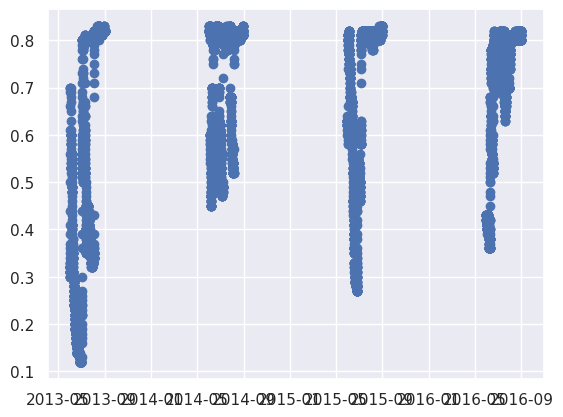

In [156]:
rpath = '/nird/datapeak/NS9600K/astridbg/arctic-cld-feedbacks/data/'
folder = 'ISMN_data_Arctic_1951_2025'
filepath = '/nird/datapeak/NS9600K/astridbg/arctic-cld-feedbacks/data/ISMN_data_Arctic_1951_2025/FMI/SODAWS/FMI_FMI_SODAWS_sm_0.100000_0.100000_ThetaProbe-ML2X-A_19510403_20251212.stm'
filepath = '/nird/datapeak/NS9600K/astridbg/arctic-cld-feedbacks/data/ISMN_data_Arctic_1951_2025/SCAN/SchorGarden/SCAN_SCAN_SchorGarden_sm_0.254000_0.254000_Hydraprobe-Analog-A_19510403_20251212.stm'
filepath = '/nird/datapeak/NS9600K/astridbg/arctic-cld-feedbacks/data/ISMN_data_Arctic_1951_2025/FMI/SAA120/FMI_FMI_SAA120_sm_0.050000_0.050000_5TE-B_19510403_20251212.stm'
filepath = '/nird/datapeak/NS9600K/astridbg/arctic-cld-feedbacks/data/ISMN_data_Arctic_1951_2025/FMI/SOD140/FMI_FMI_SOD140_sm_0.050000_0.050000_CS655-A_19510403_20251212.stm'
filepath = '/nird/datapeak/NS9600K/astridbg/arctic-cld-feedbacks/data/ISMN_data_Arctic_1951_2025/SCAN/LowerMulchatna/SCAN_SCAN_LowerMulchatna_sm_0.050800_0.050800_n.s.-A_19510403_20251212.stm'


import pandas as pd
ds = pd.read_csv(filepath,sep=' ',skiprows=1,names=['Date','Time (UTC)','Soil moisture','Flag1','Flag2'],index_col=0)
with open(filepath) as file:
    first_line = file.readline()
first_line = first_line.split(' ')
header = []
for elem in first_line:
    if elem != '':
        header.append(elem)

ds.index = pd.to_datetime(ds.index)
JJA = ds[(ds.index.month > 5) & (ds.index.month < 9)]
plt.scatter(JJA.index, JJA['Soil moisture'])